74.0
train fold 1
预测误差较大城市，绝对值误差阈值设置为50
R-squared 0.9919344866354608
R 0.9959590787956405
mae 197.8827160493827
rmse 2627.4125773946985
#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 136   pre:62.0
亳州市   real: 108   pre:17.0
宜昌市   real: 931   pre:160.0
鄂州市   real: 1391   pre:463.0
R-squared 0.8664225016965764
R 0.9308181893885489
mae 60.054054054054056
rmse 199.87414959337707
84.0
train fold 2
预测误差较大城市，绝对值误差阈值设置为50
R-squared 0.7628054559353024
R 0.8733873458754153
mae 81.14153846153846
rmse 592.9759185666818
#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
宁波市   real: 157   pre:64.0
蚌埠市   real: 160   pre:42.0
武汉市   real: 49122   pre:1106089933332329.0
荆州市   real: 1579   pre:897.0
随州市   real: 1307   pre:287.0
长沙市   real: 242   pre:386.0
R-squared 0.9983406423379089
R 0.9991699766996148
mae 30724720369044.945
rmse 184348322213867.84
82.0
train fold 3
预测误差较大城市，绝对值误差阈值设置为50
R-squared 0.9908122110460101
R 0.9953955048351435

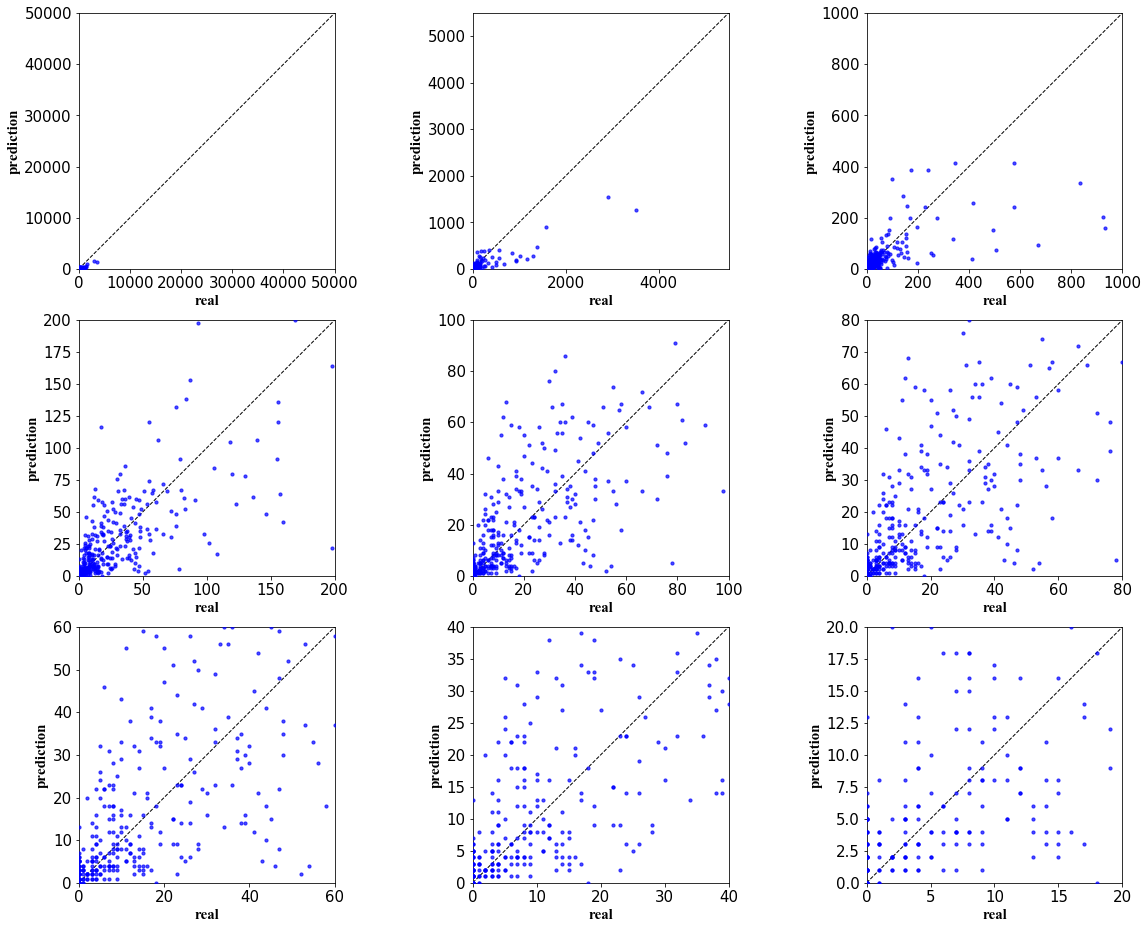

R-squared 0.8075626330152711
R 0.8986448870467528
mae 52.983333333333334
rmse 194.01388839175635


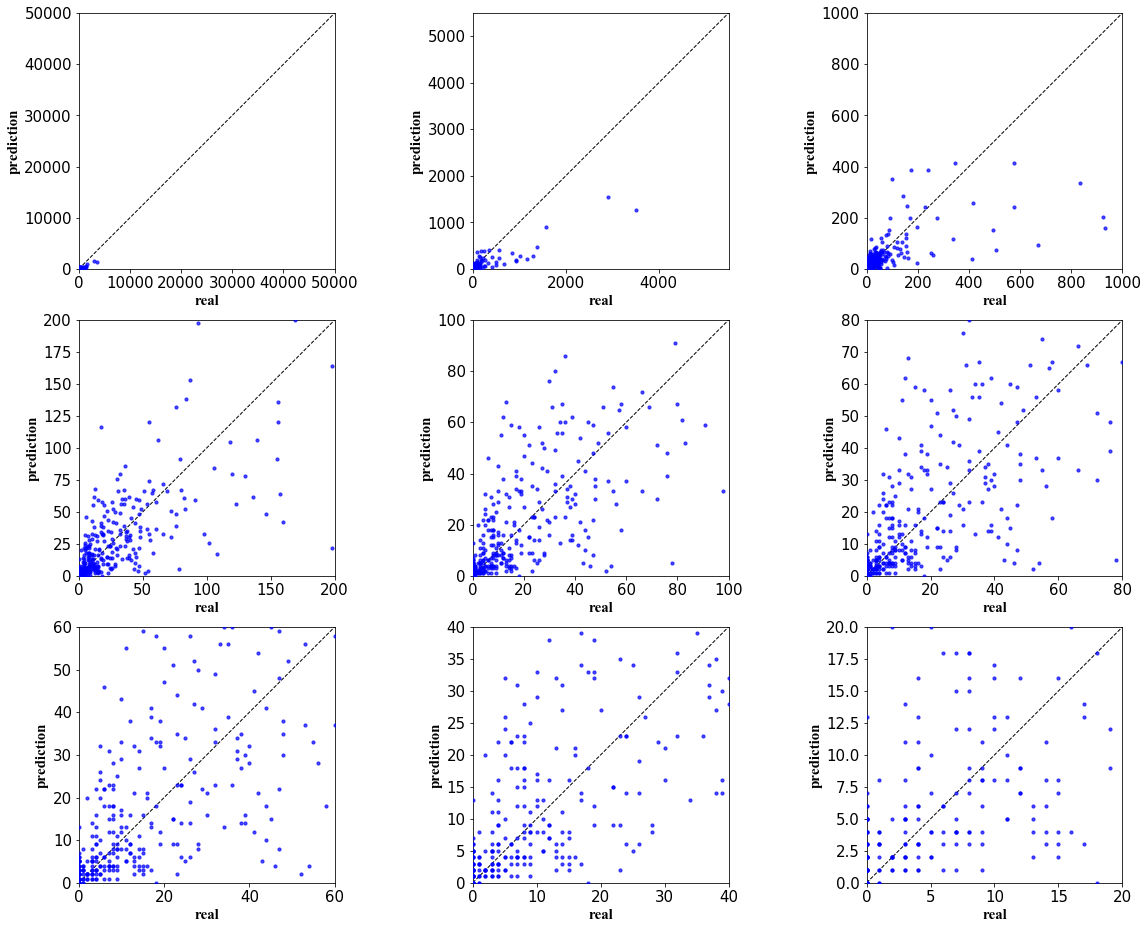

In [56]:
# -*- coding: utf-8 -*-
# @Author  : Qi Shao

"""
利用GWR建模预测
"""

# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')


# 评价指标
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

def predict_plot(real_y, prediction_y):

    ############# 设置图例并且设置图例的字体及大小 #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# 设置坐标刻度值的大小以及刻度值的字体 #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # x，y轴设置显示刻度一致
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# 疫情建模
def covid_all_predict(df, index, threshold):

    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'people', 'GDPTotal', 
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean', 'DISTANCE',
    'confirmed','confirmLog', 'X', 'Y']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog'].values.reshape((-1,1))
        train_y = train_df['confirmed'].values.reshape((-1,1)).flatten()
        u = train_df['X']
        v = train_df['Y']
        cal_coords = list(zip(u,v))

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values

        test_y = test_df['confirmed'].values.reshape((-1,1)).flatten()
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values
        
        u = test_df['X']
        v = test_df['Y']
        pred_coords = list(zip(u,v))
        
        #Calibrate GWR model
        gwr_selector = Sel_BW(np.array(cal_coords), train_y_log, train_x)
        gwr_bw = gwr_selector.search(criterion = 'AICc')
        #gwr_bw = gwr_selector.search(bw_min=40)
        print(gwr_bw)
        model = GWR(np.array(cal_coords), train_y_log, train_x, gwr_bw, kernel='gaussian')
        gwr_results = model.fit()

        scale = gwr_results.scale
        residuals = gwr_results.resid_response

        predict_ytrain_log = model.predict(np.array(cal_coords), train_x, scale, residuals).predictions.flatten()
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = model.predict(np.array(pred_coords), test_x, scale, residuals).predictions.flatten()
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)
        
        
        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = list(train_y)
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                #print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])
                pass

        evaluation(train_yy, predict_train_y)


        print("#########################################")
        print("test fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = list(test_y)
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_yy, predict_test_y)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)
    predict_plot(real_y, prediction_y)

    return case, df_predict


# main
if __name__ == '__main__':


    df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")
    #df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")
    #df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
    kf = KFold(10, True)
    index = []
    for train_index, test_index in kf.split(df):
        index.append((train_index, test_index))


    # 全时间段建模
    case, df_predict = covid_all_predict(df, index, threshold = 50)
    df = pd.merge(df, df_predict, how='inner', on='id')
    df['diff'] = df['confirmed'] - df['predict']

    df.to_file("../result/COVID_gwr.shp", encoding='utf-8')
    #df.to_file("../result/COVID_gwr_before.shp", encoding='utf-8')
    #df.to_file("../result/COVID_gwr_after.shp", encoding='utf-8')
    
    # 不含武汉
    epidemicIds = [420100]
    df = df[~df['id'].isin(epidemicIds)]
    evaluation(df['confirmed'], df['predict'])
    predict_plot(df['confirmed'], df['predict'])